In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
plt.style.use('seaborn-notebook')
plt.style.use('ggplot')

In [5]:
import pymc3 as pm

# Note on using `PyMC3` as opposed to `statsmodels`

This chapters talks about the difference between `stan-glm` and `glm` in R, which finally revealed why when I was using `statsmodels` in the previous chapters, the standard errors are slightly off from the book: `statsmodel` uses classical fitting, whereas `stan-glm` uses Bayesian fitting and the "errors" were shown as `MAD_sd`. We will try to use `pyMC3` as the closest python relative in this notebook, and for the question that compares `stan-glm` to `glm`, we will be using `statsmodels` vs `pymc3`

# 8.1 Least Squares

In [6]:
data = pd.read_csv('../ROS-Examples/ElectionsEconomy/data/hibbs.dat', sep=' ')

In [7]:
data.head()

,year,growth,vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson
2,1960,0.85,49.91,Nixon,Kennedy
3,1964,4.21,61.34,Johnson,Goldwater
4,1968,3.02,49.60,Humphrey,Nixon


In [8]:
def rss(x,y,a,b):
    resid = y-(a+b*x)
    return sum(np.power(resid,2))

In [9]:
a_fixed = 46.3 # a is intercept 
b_fixed = 3 #b is slope

In [10]:
x = data['growth']
y = data['vote']

In [11]:
a_free_rss = []
for a in np.linspace(20,80,100):
    a_free_rss.append(rss(x,y,a,b_fixed))

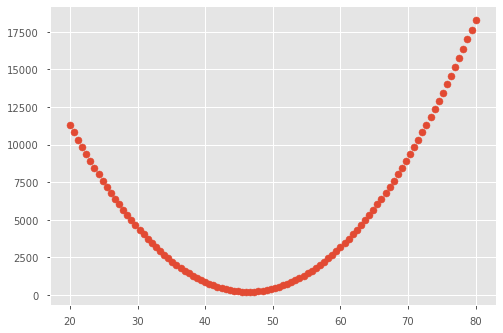

In [12]:
plt.scatter(np.linspace(20,80,100), a_free_rss)

In [13]:
b_free_rss = []
for b in np.linspace(1,10,100):
    b_free_rss.append(rss(x,y,a_fixed,b))

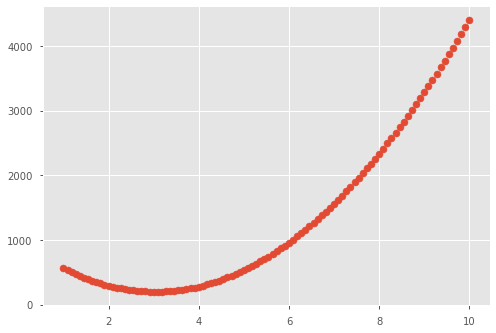

In [14]:
plt.scatter(np.linspace(1,10,100), b_free_rss)

# 8.2 Maximum Likelihood

In [15]:
def rss_lh(x,y,a,b,sigma):
    p = np.sum(-1/2*np.power((y-(a+b*x))/sigma,2)-np.log(sigma))    
    return p

In [16]:
sigma_true = np.sqrt(1/len(x)*np.sum(np.power(y-(a_fixed+b_fixed*x),2)))
sigma_true

3.521737852254197

In [17]:
sigma_classic = np.sqrt(1/(len(x)-2)*np.sum(np.power(y-(a_fixed+b_fixed*x),2)))
sigma_classic

3.764896128333803

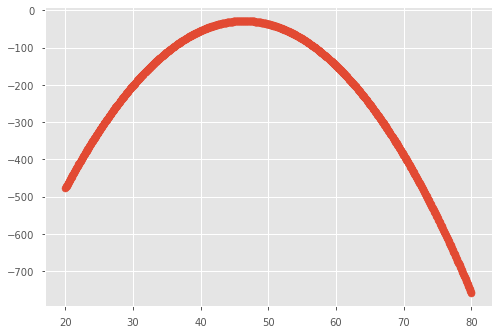

In [18]:
sample_space = np.linspace(20,80,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss_lh(x,y,a,b_fixed,sigma_true))
plt.scatter(sample_space, a_free_rss)

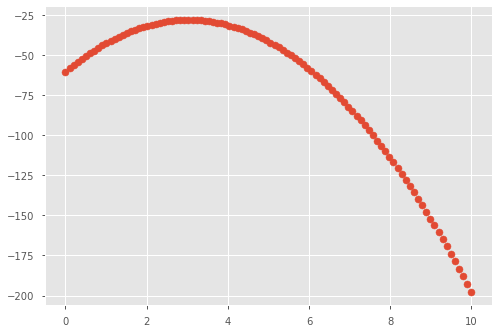

In [19]:
sample_space = np.linspace(0,10,100)
b_free_rss = []
for b in sample_space:
    b_free_rss.append(rss_lh(x,y,a_fixed,b,sigma_true))
plt.scatter(sample_space, b_free_rss)

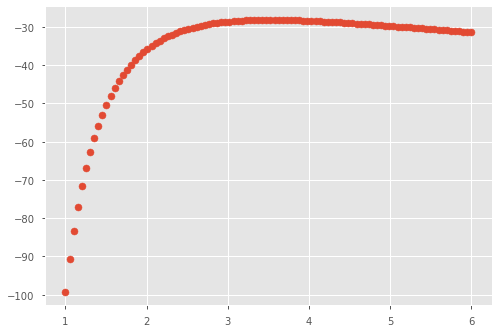

In [20]:
sample_space = np.linspace(1,6,100)
sigma_free_rss = []
for sigma in sample_space:
    sigma_free_rss.append(rss_lh(x,y,a_fixed,b_fixed,sigma))
plt.scatter(sample_space, sigma_free_rss)

# 8.3 Least Absolute deviation

In [21]:
def rss_abs(x,y,a,b):
    resid = y-(a+b*x)
    return sum(np.abs(resid))

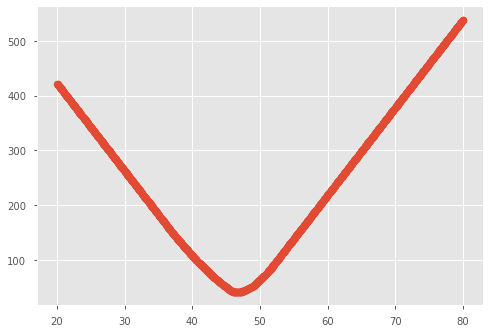

In [22]:
sample_space = np.linspace(20,80,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss_abs(x,y,a,b_fixed))
plt.scatter(sample_space, a_free_rss)

In [23]:
min(a_free_rss)

41.35999999999999

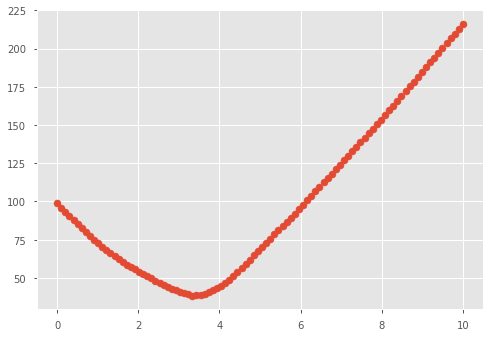

In [24]:
sample_space = np.linspace(0,10,100)
b_free_rss = []
for b in sample_space:
    b_free_rss.append(rss_abs(x,y,a_fixed,b))
plt.scatter(sample_space, b_free_rss)

In [25]:
min(b_free_rss)

38.35333333333332

# 8.4 Least squares and least absolute deviatioon

In [26]:
x = np.linspace(-10,10,100)
y = np.power(x,2)

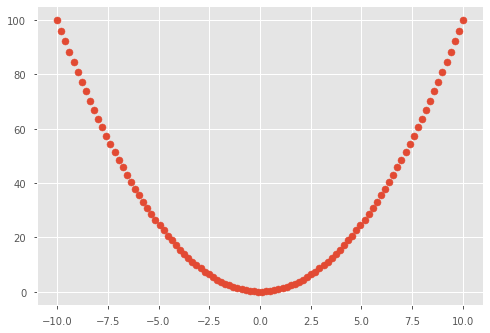

In [27]:
plt.scatter(x,y)

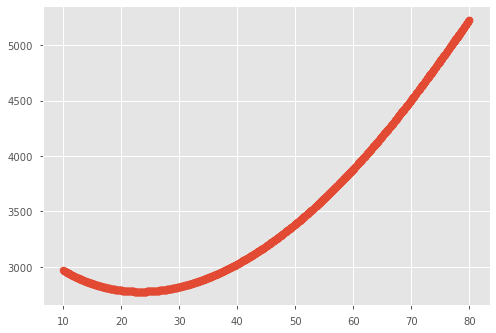

In [28]:
sample_space = np.linspace(10,80,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss_abs(x,y,a,b_fixed))
plt.scatter(sample_space, a_free_rss)

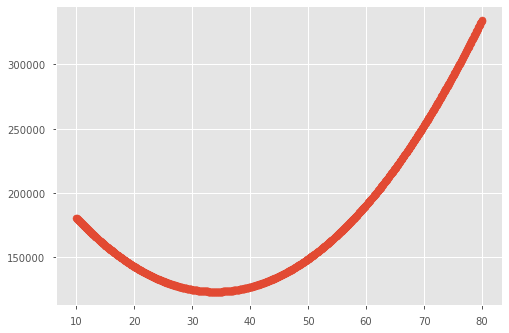

In [29]:
sample_space = np.linspace(10,80,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss(x,y,a,b_fixed))
plt.scatter(sample_space, a_free_rss)

Basically, if the model is not linear...if it is linear the two agrees

Okay maybe let's try big errors

In [30]:
x = np.linspace(-10,10,100)
y = 5*x+6+np.random.normal(0, 10, 100)

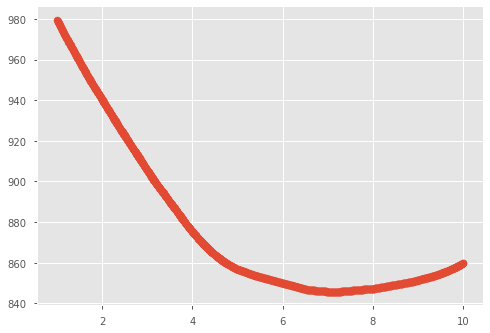

In [31]:
sample_space = np.linspace(1,10,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss_abs(x,y,a,5))
plt.scatter(sample_space, a_free_rss)

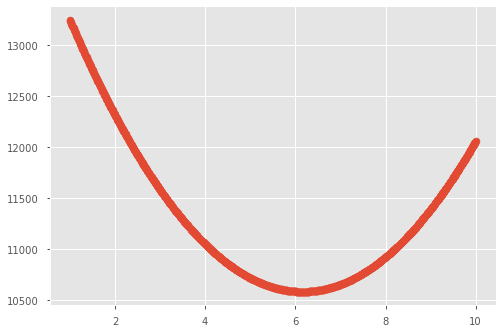

In [32]:
sample_space = np.linspace(1,10,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss(x,y,a,5))
plt.scatter(sample_space, a_free_rss)

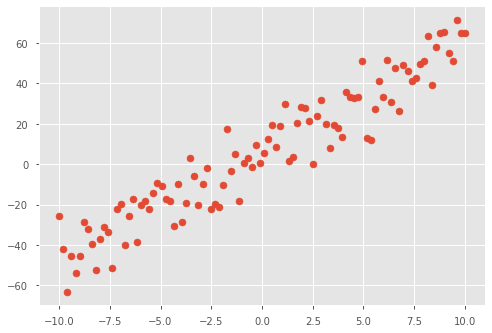

In [33]:
plt.scatter(x,y)

essentially we need big errors, so influenced by outliers

# 8.5 influence of individual data points

Skipping due to writing on the book, but it would be the biggest away point on the far end

# 8.6 Influence of individual data points

In [34]:
def influence_slope(x):
    x_bar = np.mean(x)
    return (x-x_bar)/np.sum(np.power(x-x_bar, 2))

In [35]:
x = data['growth']
y = data['vote']

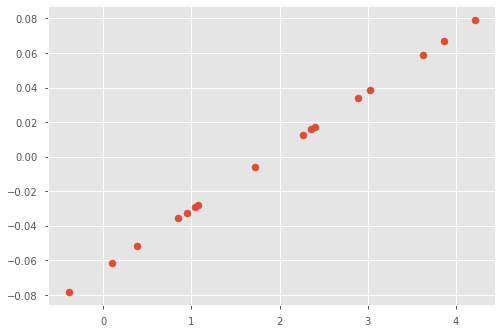

In [36]:
plt.scatter(x, influence_slope(x))

In [37]:
# we will actually do least square, i.e. statsmodel
b_hat = []
for i in range (0, len(x)):
    new_y = y.copy()
    new_y[i] += 1
    x_sm = sm.add_constant(x)
    res = sm.GLM(new_y, x_sm).fit()
    print(f"b_hat is {res.params[1]}")
    b_hat.append(res.params[1])

b_hat is 3.0777293592899007
b_hat is 3.0945027710360815
b_hat is 3.0246706078479004
b_hat is 3.13968828839314
b_hat is 3.098952859866701
b_hat is 3.1194917313926354
b_hat is 3.032543841932843
b_hat is 2.9822236066943013
b_hat is 3.12770728000301
b_hat is 3.073279270459282
b_hat is 3.008581825152585
b_hat is 3.031174583831114
b_hat is 3.076360101188172
b_hat is 3.054451971560508
b_hat is 2.998997018440482
b_hat is 3.0280937531022243


In [38]:
true_res = sm.GLM(y,x_sm).fit()

In [39]:
b_true = sm.GLM(y,x_sm).fit().params[1]

In [40]:
b_true

3.06052805438693

In [41]:
np.array(b_hat)-b_true

array([ 0.0172013 ,  0.03397472, -0.03585745,  0.07916023,  0.03842481,
        0.05896368, -0.02798421, -0.07830445,  0.06717923,  0.01275122,
       -0.05194623, -0.02935347,  0.01583205, -0.00607608, -0.06153104,
       -0.0324343 ])

In [42]:
influence_slope(x)

0     0.017201
1     0.033975
2    -0.035857
3     0.079160
4     0.038425
5     0.058964
6    -0.027984
7    -0.078304
8     0.067179
9     0.012751
10   -0.051946
11   -0.029353
12    0.015832
13   -0.006076
14   -0.061531
15   -0.032434
Name: growth, dtype: float64

In [43]:
np.array(b_hat)-b_true - influence_slope(x)

0    -4.961309e-16
1    -2.706169e-16
2    -7.979728e-16
3     2.775558e-16
4    -2.775558e-17
5    -1.235123e-15
6    -1.595946e-16
7     4.163336e-17
8    -6.383782e-16
9     1.457168e-16
10   -2.289835e-16
11    3.816392e-17
12   -2.949030e-16
13    2.151057e-16
14    2.636780e-16
15    4.857226e-16
Name: growth, dtype: float64

# 8.7 Least squares slope as a weighted average of individual slopes

Just a math exercise, but is actually difficult, the key is to recognize that $\sum_{i}^{n} x = n\overline{x}$

# 8.8 Comparing `pymc3` and `statsmodel`

In [44]:
x = np.random.uniform(0,20,100)
error = np.random.normal(0,5,100)
y = 2+3*x+error

In [45]:
x_sm = sm.add_constant(x)
res = sm.GLM(y, x_sm).fit()

In [46]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          18.199
Method:                          IRLS   Log-Likelihood:                -285.95
Date:                Mon, 24 May 2021   Deviance:                       1783.5
Time:                        11:59:08   Pearson chi2:                 1.78e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5165      0.922      3.815      0.000       1.710       5.323
x1             2.8234      0.075     37.404      0.000       2.675       2.971
==============================================================================
"""

In [86]:
with pm.Model() as model:
    pm.glm.GLM(x,y,intercept=True)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sd, x0, Intercept]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 9 seconds.


/home/jfyu/miniconda3/envs/ros/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb151ec4d60>,
      dtype=object)

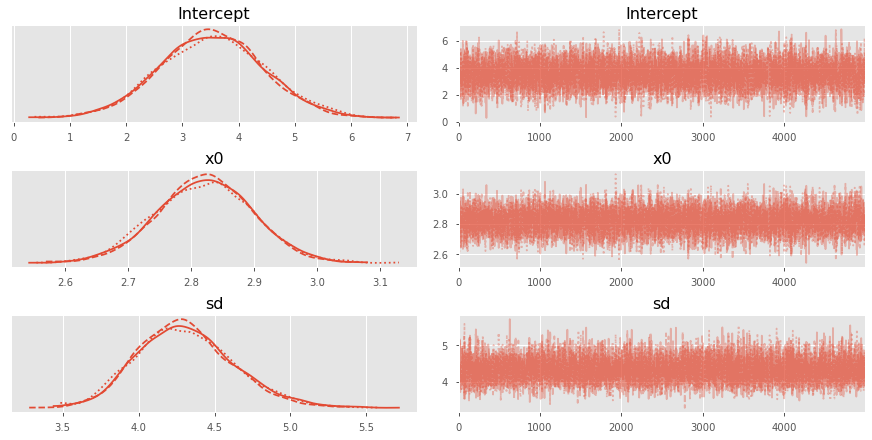

In [74]:
pm.traceplot(trace)

In [83]:
intercept = max(trace[:3000]['Intercept'])
intercept

6.8477815863150315

In [84]:
slope = max(trace[:3000]['x0'])
slope

3.130683898677267

In [72]:
max(trace['sd'])

5.620752964619886

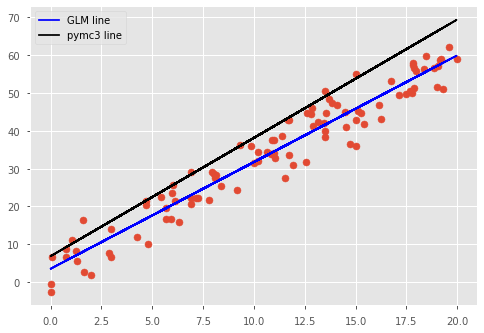

In [85]:
plt.scatter(x,y)
plt.plot(x, res.params[0]+res.params[1]*x, color= 'b', label='GLM line')
plt.plot(x, intercept+slope*x, color='k', label='pymc3 line')
plt.legend()

Doesn't seem to take much to get the wrong line................
this is a weird one needs further dive, but it's mostly a code issue, leave for now

# 8.9 Leave-one-out cross validation

In [87]:
data

,year,growth,vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson
2,1960,0.85,49.91,Nixon,Kennedy
3,1964,4.21,61.34,Johnson,Goldwater
4,1968,3.02,49.60,Humphrey,Nixon
5,1972,3.62,61.79,Nixon,McGovern
6,1976,1.08,48.95,Ford,Carter
7,1980,-0.39,44.70,Carter,Reagan
8,1984,3.86,59.17,Reagan,Mondale
9,1988,2.27,53.94,"Bush, Sr.",Dukakis


In [96]:
from sklearn.model_selection import LeaveOneOut

In [97]:
loo = LeaveOneOut()

In [98]:
loo.get_n_splits(data['vote'])

16

Can't compare `stan_glm` since we can't figure out how to do that in Python

In [129]:
cv_res_n = []
for train_index, test_index in loo.split(data[['growth', 'vote']]):
    x = data['growth'][train_index]
    y = data['vote'][train_index]
    x_sm = sm.add_constant(x)
    res = sm.GLM(y,x_sm).fit()
    x_test = data['growth'][test_index]
    y_test = data['vote'][test_index]
    cv_residual = y_test - (res.params[0]+res.params[1]*x_test)
    cv_res_n.append(cv_residual.values[0])

In [130]:
cv_res_n

[-9.681707405723408,
 2.9514103314942943,
 1.1788607384887655,
 2.9260420212630294,
 -6.5861499009409386,
 5.339219044567301,
 -0.6593081272868488,
 -0.46684081913613085,
 1.3761544994171118,
 0.7986632670708644,
 -1.002302487164549,
 5.819611658317484,
 -3.4407342808053016,
 -0.29020721086688894,
 -0.28262353123204775,
 3.137350197980574]

In [131]:
sigma_cv = np.sqrt(1/len(cv_res_n)*np.sum(np.power(cv_res_n,2)))

In [132]:
sigma_cv

3.9066037292468696

formula 8.5

In [133]:
sigma_classic = np.sqrt(1/(len(data['growth'])-2)*np.sum(np.power(data['vote'] - (res.params[0]+res.params[1]*data['growth']), 2)))

In [135]:
sigma_classic

3.7719864869488466

In [134]:
sigma_true # this uses 1/n as opposed to 1/(n-2) in the classic case

3.521737852254197

In [117]:
sigma_stan = 3.9 # see sec.7.1

Looks like leave-one-out is the closest to stan. It fixes the overfitting issue that is coming out of the sigma_true, and sigma_classic tries to fix it, but I think the sample size is too small so it did not do a great job

# 8.10 Leave one out cross validation

In [144]:
x_data = np.linspace(-10,10,10)
y_data = 5*x_data+6+np.random.normal(0, 10, 10)

In [145]:
cv_res_n = []
for train_index, test_index in loo.split(x_data):
    x = x_data[train_index]
    y = y_data[train_index]
    x_sm = sm.add_constant(x)
    res = sm.GLM(y,x_sm).fit()
    x_test = x_data[test_index]
    y_test = y_data[test_index]
    cv_residual = y_test - (res.params[0]+res.params[1]*x_test)
    cv_res_n.append(cv_residual[0])

In [146]:
sigma_cv = np.sqrt(1/len(cv_res_n)*np.sum(np.power(cv_res_n,2)))

In [147]:
sigma_cv

14.058865126056567

In [148]:
x_sm = sm.add_constant(x_data)
res = sm.GLM(y_data,x_sm).fit()

In [149]:
sigma_classic = np.sqrt(1/(len(x_data)-2)*np.sum(np.power(y_data - (res.params[0]+res.params[1]*x_data), 2)))

In [150]:
sigma_classic

12.62498407530528

Fewer points. So every point has a larger influence on the line. This would make leave-one-out really large because the residuals would be huge. 